In [489]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.ensemble import IsolationForest

from pathlib import Path


project_root = Path.cwd().parent

# Data folder
data_dir = project_root / "data"

# Input CSVs
rides_csv = data_dir / "uber_hackathon_v2_mock_data.xlsx - rides_trips.csv"
eats_csv = data_dir / "uber_hackathon_v2_mock_data.xlsx - eats_orders.csv"

# Output CSV
output_file = data_dir / "hourly_avg_combined_score.csv"



## Heuristica 1: Trip Score

In [490]:
def trip_score(earning, tips, km, alpha=0.1):
    """
    Compute a score for a trip based on revenue minus distance penalty.

    Parameters:
        earning (float): Net earning of the trip
        tips (float): Tips for the trip
        km (float): Distance traveled in kilometers
        alpha (float): Weight of distance penalty per km (default 0.5)

    Returns:
        float: Trip score
    """
    revenue = earning + tips
    score = revenue - alpha * km
    return score


## Compute average sum of trip scores of a driver in a 2 hour interval , for each week


In [491]:
def compute_hour_of_week(ts):
    """
    Given a pandas Timestamp, returns the hour of the week (0-167).
    Monday 00:00 = 0, Sunday 23:00 = 167
    """
    # Monday=0, Sunday=6
    day_of_week = ts.weekday()  
    hour_of_day = ts.hour
    return day_of_week * 24 + hour_of_day

# --- Function to compute 2-hour avg scores by city, keeping week column ---
def compute_2hour_avg_score_by_city_with_week(rides_csv, eats_csv, output_file, alpha=0.5):
    combined_trips = []

    for csv_path, role in [(rides_csv, 'rides'), (eats_csv, 'eats')]:
        trips = pd.read_csv(csv_path)
        trips['start_time'] = pd.to_datetime(trips['start_time'])

        # Compute trip score
        if role == 'rides':
            trips['score'] = trip_score(trips['net_earnings'], trips['tips'], trips['distance_km'], alpha)
            trips = trips.rename(columns={'driver_id':'earner_id'})
        else:
            trips['score'] = trip_score(trips['net_earnings'], trips['tip_eur'], trips['distance_km'], alpha)
            trips = trips.rename(columns={'courier_id':'earner_id'})

        # Compute week and 2-hour interval
        trips['week'] = trips['start_time'].dt.isocalendar().week
        trips['job_hour'] = trips['start_time'].apply(compute_hour_of_week)
        trips['job_hour_2h'] = (trips['job_hour'] // 2) * 2

        combined_trips.append(trips[['earner_id','week','job_hour_2h','score','city_id']])

    all_trips = pd.concat(combined_trips, ignore_index=True)

    # Sum per earner per 2-hour interval per week
    earner_week_interval_sum = all_trips.groupby(['earner_id','week','job_hour_2h','city_id']).agg(
        total_score=('score','sum')
    ).reset_index()

    # Average across earners per 2-hour interval per week per city
    avg_score_city_2h_week = earner_week_interval_sum.groupby(['week','job_hour_2h','city_id']).agg(
        avg_score_per_earner=('total_score','mean')
    ).reset_index()

    # Save to CSV
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    avg_score_city_2h_week.to_csv(output_file, index=False)
    print(f"Saved 2-hour average scores by city with week column to: {output_file}")

    # Summary
    n_earners = all_trips['earner_id'].nunique()
    n_weeks = all_trips['week'].nunique()
    n_trips = len(all_trips)
    n_cities = all_trips['city_id'].nunique()
    print(f"Total trips processed: {n_trips}")
    print(f"Unique earners: {n_earners}")
    print(f"Number of weeks: {n_weeks}")
    print(f"Number of cities: {n_cities}")

    return avg_score_city_2h_week

# --- Run ---
output_file_with_week = data_dir / "hourly_avg_2h_by_city_with_week.csv"
hourly_avg_2h_by_city_week = compute_2hour_avg_score_by_city_with_week(rides_csv, eats_csv, output_file_with_week, alpha=0.5)
print(hourly_avg_2h_by_city_week.head())


Saved 2-hour average scores by city with week column to: c:\Code\Junc\data\hourly_avg_2h_by_city_with_week.csv
Total trips processed: 5500
Unique earners: 360
Number of weeks: 18
Number of cities: 5
   week  job_hour_2h  city_id  avg_score_per_earner
0     1            0        3                 1.850
1     1            0        4                 6.210
2     1            0        5                 6.440
3     1            2        3                 4.535
4     1            2        4                 5.640


## Detect anomalous weeks and remove them

City 3 - Example anomaly: Week 2 - Highest score: 295.66


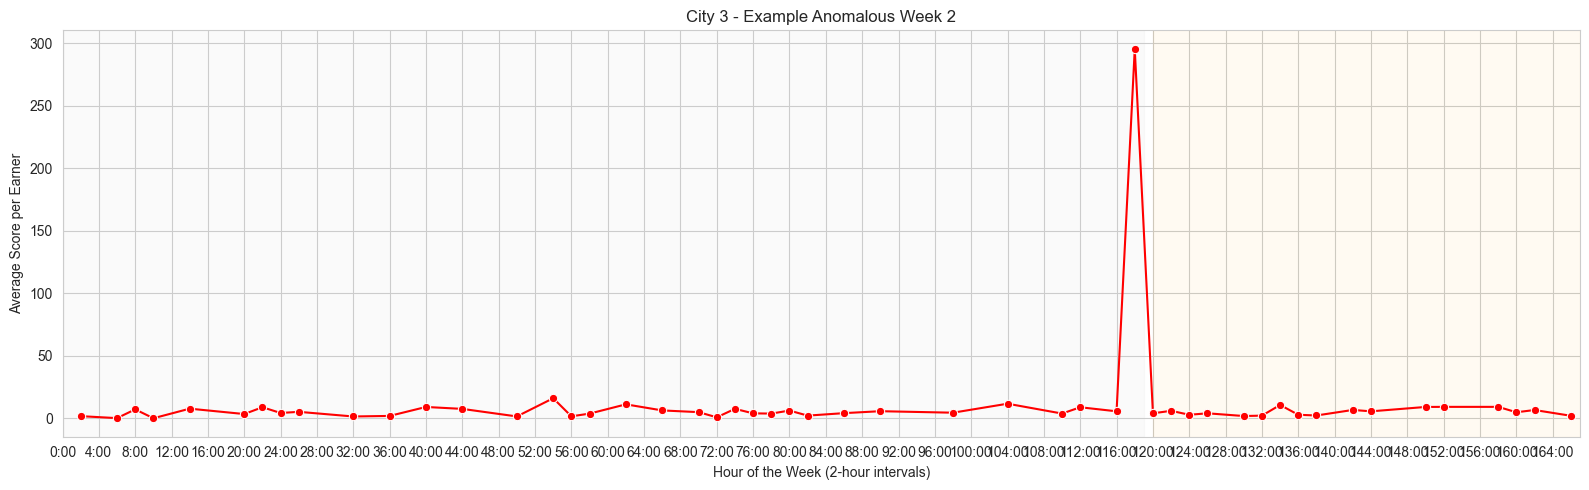

Saved cleaned CSV without anomalies for all cities to: c:\Code\Junc\data\hourly_avg_2h_by_city_cleaned_all_cities.csv
Saved CSV averaged over weeks to: c:\Code\Junc\data\hourly_avg_2h_by_city_avg_over_weeks.csv


In [ ]:
# --- Paths ---
project_root = Path.cwd().parent
data_dir = project_root / "data"
csv_file = data_dir / "hourly_avg_2h_by_city_with_week.csv"

# --- Read CSV ---
df = pd.read_csv(csv_file)

# --- Prepare cleaned DataFrame ---
cleaned_rows = []  # store only normal rows
anomaly_shown = False  

# --- Loop over all cities ---
for city_id in df['city_id'].unique():
    city_df = df[df['city_id'] == city_id].copy()  # avoid SettingWithCopyWarning
    
    # Pivot weeks x 2-hour intervals
    week_matrix = city_df.pivot(index='week', columns='job_hour_2h', values='avg_score_per_earner').fillna(0)
    
    # Fit Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(week_matrix)
    
    # Predict anomalies
    preds = iso.predict(week_matrix)  # 1 = normal, -1 = anomaly
    
    for week, pred in zip(week_matrix.index, preds):
        week_data = city_df[city_df['week'] == week]
        if pred == -1:
            if not anomaly_shown:
                # First anomalous week: plot and report as an example
                max_score = week_data['avg_score_per_earner'].max()
                print(f"City {city_id} - Example anomaly: Week {week} - Highest score: {max_score}")
                
                plt.figure(figsize=(16,5))
                sns.lineplot(data=week_data, x='job_hour_2h', y='avg_score_per_earner', 
                             marker='o', color='red')
                plt.title(f"City {city_id} - Example Anomalous Week {week}")
                plt.xlabel("Hour of the Week (2-hour intervals)")
                plt.ylabel("Average Score per Earner")
                plt.xticks(ticks=range(0, 168, 4), labels=[f"{i}:00" for i in range(0, 168, 4)])
                plt.xlim(0, 167)
                plt.axvspan(0, 119, color='lightgray', alpha=0.1)  # Mon-Fri
                plt.axvspan(120, 167, color='orange', alpha=0.05)  # Sat-Sun
                plt.tight_layout()
                plt.show()
                anomaly_shown = True
            # do not add anomalies to cleaned data
        else:
            # Normal week: append all rows to cleaned_rows
            cleaned_rows.extend(week_data.to_dict('records'))

# --- Create cleaned DataFrame from rows ---
cleaned_df = pd.DataFrame(cleaned_rows)

# --- Save cleaned CSV ---
output_clean = data_dir / "hourly_avg_2h_by_city_cleaned_all_cities.csv"
cleaned_df.to_csv(output_clean, index=False)
print(f"Saved cleaned CSV without anomalies for all cities to: {output_clean}")

# --- Average over weeks for each city ---
avg_over_weeks = cleaned_df.groupby(['city_id','job_hour_2h']).agg(
    avg_score_per_earner=('avg_score_per_earner','mean')
).reset_index()

# --- Save averaged CSV ---
output_avg = data_dir / "hourly_avg_2h_by_city_avg_over_weeks.csv"
avg_over_weeks.to_csv(output_avg, index=False)
print(f"Saved CSV averaged over weeks to: {output_avg}")


## Plot the average score of each 2 hours

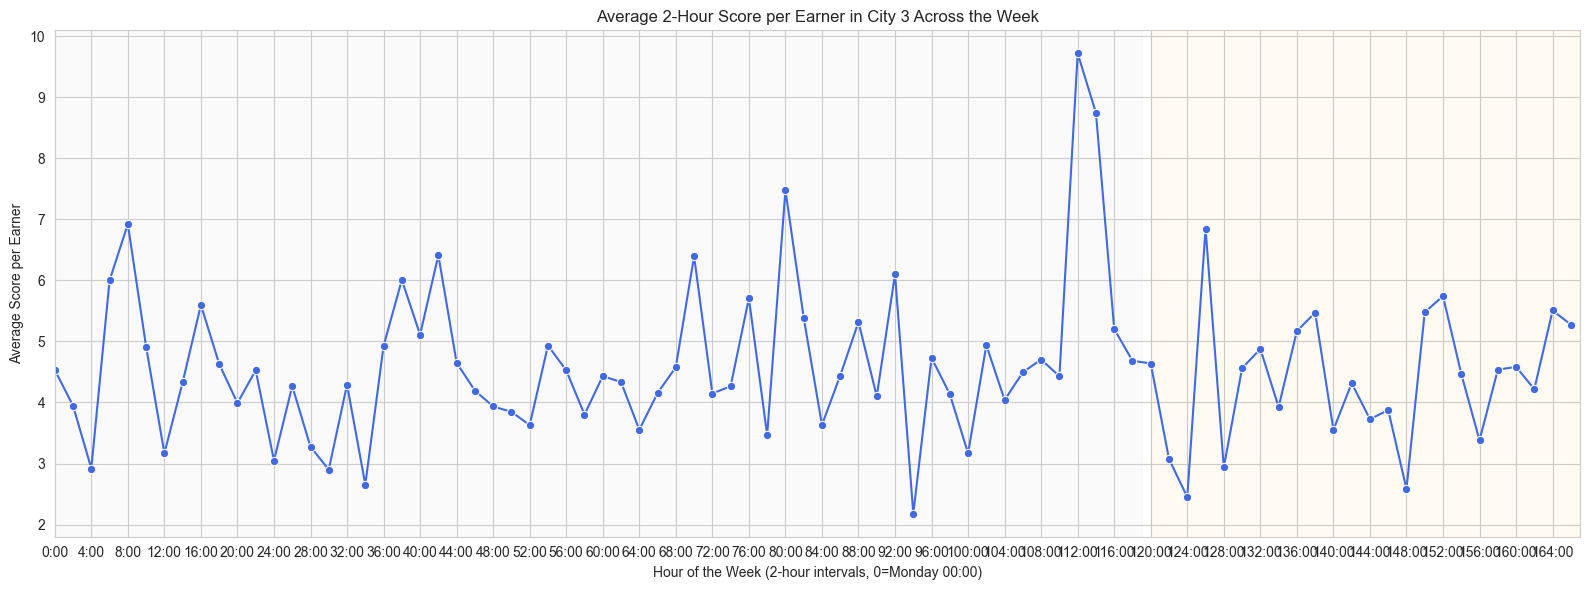

In [493]:
# CSV with averaged scores over weeks
avg_csv = data_dir / "hourly_avg_2h_by_city_avg_over_weeks.csv"
avg_df = pd.read_csv(avg_csv)

# --- Select City 2 ---
city_id = 3
city_data = avg_df[avg_df['city_id'] == city_id]

# --- Full week plot (2-hour intervals) ---
plt.figure(figsize=(16,6))
sns.set_style("whitegrid")
sns.lineplot(data=city_data, x='job_hour_2h', y='avg_score_per_earner', marker='o', color='royalblue')
plt.xlabel("Hour of the Week (2-hour intervals, 0=Monday 00:00)")
plt.ylabel("Average Score per Earner")
plt.title(f"Average 2-Hour Score per Earner in City {city_id} Across the Week")
plt.xticks(ticks=range(0, 168, 4), labels=[f"{i}:00" for i in range(0, 168, 4)])
plt.xlim(0, 167)
plt.axvspan(0, 119, color='lightgray', alpha=0.1)  # Mon-Fri
plt.axvspan(120, 167, color='orange', alpha=0.05)  # Sat-Sun
plt.tight_layout()
plt.show()

# Just friday

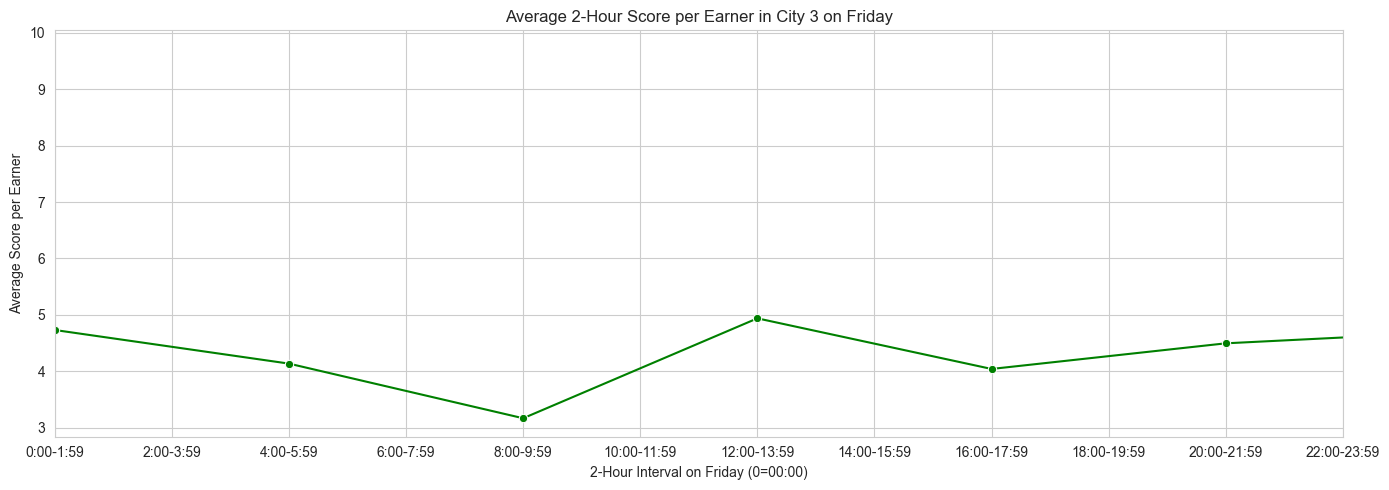

In [494]:
friday_data = city_data[(city_data['job_hour_2h'] >= 96) & (city_data['job_hour_2h'] <= 119)].copy()
friday_data['friday_2h'] = friday_data['job_hour_2h'] - 96  # 0-23 for Friday (2-hour blocks)

plt.figure(figsize=(14,5))
sns.lineplot(data=friday_data, x='friday_2h', y='avg_score_per_earner', marker='o', color='green')
plt.xlabel("2-Hour Interval on Friday (0=00:00)")
plt.ylabel("Average Score per Earner")
plt.title(f"Average 2-Hour Score per Earner in City {city_id} on Friday")
plt.xticks(ticks=range(0, 12), labels=[f"{i*2}:00-{i*2+1}:59" for i in range(0, 12)])
plt.xlim(0, 11)
plt.tight_layout()
plt.show()

## The same city with the anomalies still there

City 3 - Largest average 2-hour score over weeks: 31.135227272727274


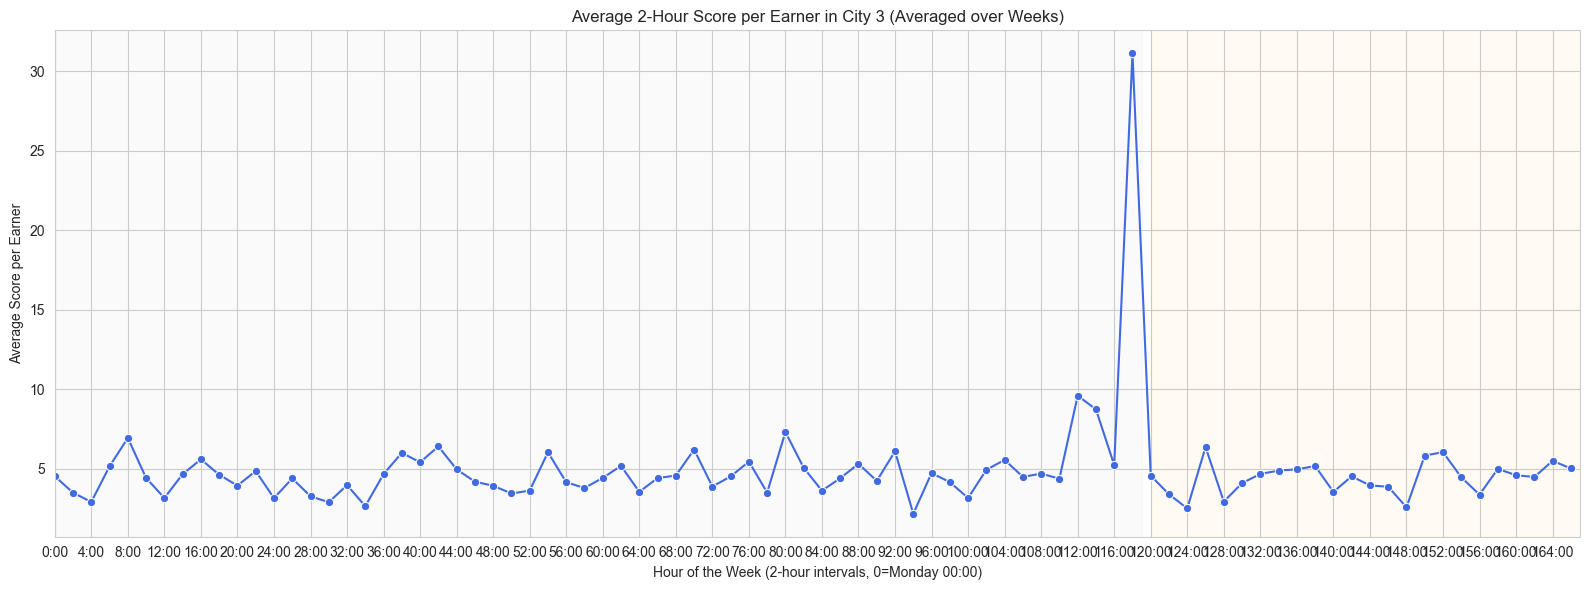

In [495]:
# --- Read CSV with week column ---
csv_file = data_dir / "hourly_avg_2h_by_city_with_week.csv"
df = pd.read_csv(csv_file)

# --- Select City 3 ---
city_id = 3
city_df = df[df['city_id'] == city_id]

# --- Average across weeks per 2-hour interval ---
avg_city_2h = city_df.groupby('job_hour_2h').agg(
    avg_score_per_earner=('avg_score_per_earner','mean')
).reset_index()

# --- Print the largest average score ---
max_score = avg_city_2h['avg_score_per_earner'].max()
print(f"City {city_id} - Largest average 2-hour score over weeks: {max_score}")

# --- Full week plot (2-hour intervals) ---
plt.figure(figsize=(16,6))
sns.set_style("whitegrid")
sns.lineplot(data=avg_city_2h, x='job_hour_2h', y='avg_score_per_earner', marker='o', color='royalblue')
plt.xlabel("Hour of the Week (2-hour intervals, 0=Monday 00:00)")
plt.ylabel("Average Score per Earner")
plt.title(f"Average 2-Hour Score per Earner in City {city_id} (Averaged over Weeks)")
plt.xticks(ticks=range(0, 168, 4), labels=[f"{i}:00" for i in range(0, 168, 4)])
plt.xlim(0, 167)
plt.axvspan(0, 119, color='lightgray', alpha=0.1)  # Mon-Fri
plt.axvspan(120, 167, color='orange', alpha=0.05)  # Sat-Sun
plt.tight_layout()
plt.show()
